In [2]:
import wrangle

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

# DBSCAN import
from sklearn.cluster import DBSCAN

# Scaler import
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = wrangle.prep_logs()

In [4]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False


## 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [5]:
def one_program_df_prep(df, program_name):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.program == program_name]
    df = df[df.name != 'Staff']
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program = df['path'].resample('d').count()
    return pages_one_program

In [6]:
def compute_pct_b(pages_one_program, span, weight, program_name):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_program.ewm(span=span).mean()
    stdev = pages_one_program.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_program, midband, bb], axis=1)
    my_df.columns = ['pages_one_program', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_program'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['program'] = program_name
    return my_df

In [7]:
def plot_bands(my_df, program):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_program, label='Number of Pages, Progarm: '+str(program))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [8]:
def find_anomalies(df, program, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_program = one_program_df_prep(df, program)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_program, span, weight, program)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, program)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

In [9]:
program = 'Data Science'
span = 30
weight = 3.5

In [10]:
user_df = find_anomalies(df, program, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, program, span, weight)
#anomalies = pd.concat([anomalies, user_df], axis=0)

In [11]:
anomalies = pd.DataFrame()
for u in list(df.program.unique()):
    user_df = find_anomalies(df, u, span, weight)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [12]:
anomalies

,pages_one_program,midband,ub,lb,pct_b,program
date_time,,,,,,
2020-05-15,79,6.945383,76.234598,-62.343833,1.019956,Full-Stack PHP
2020-08-02,72,6.157982,71.876593,-59.560629,1.000939,Full-Stack PHP
2020-11-05,44,3.100158,41.619692,-35.419376,1.030897,Full-Stack PHP


In [13]:
anomalies.sort_values(by='pct_b', ascending=False)

,pages_one_program,midband,ub,lb,pct_b,program
date_time,,,,,,
2020-11-05,44,3.100158,41.619692,-35.419376,1.030897,Full-Stack PHP
2020-05-15,79,6.945383,76.234598,-62.343833,1.019956,Full-Stack PHP
2020-08-02,72,6.157982,71.876593,-59.560629,1.000939,Full-Stack PHP


In [14]:
df_php = one_program_df_prep(df, 'Full-Stack PHP')

<AxesSubplot:xlabel='date_time'>

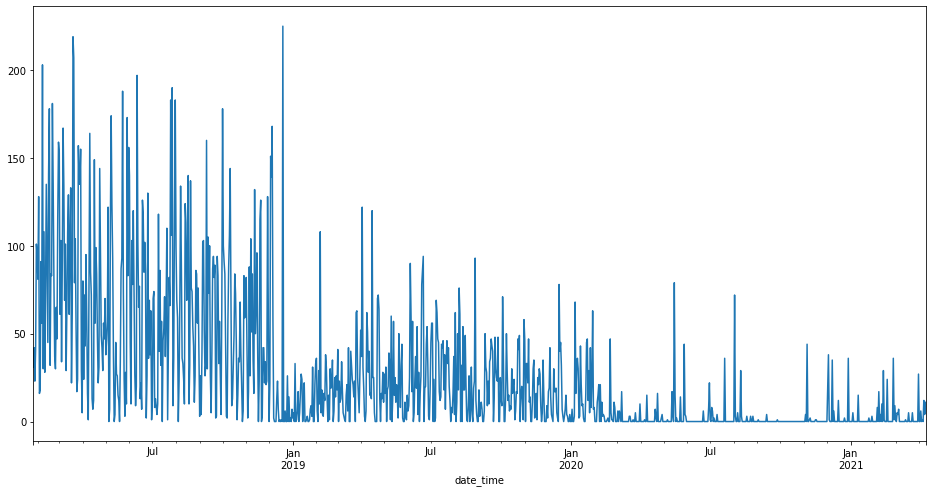

In [15]:
df_php.plot(figsize=(16,8))

In [16]:
df_java = one_program_df_prep(df, 'Full-Stack Java')

<AxesSubplot:xlabel='date_time'>

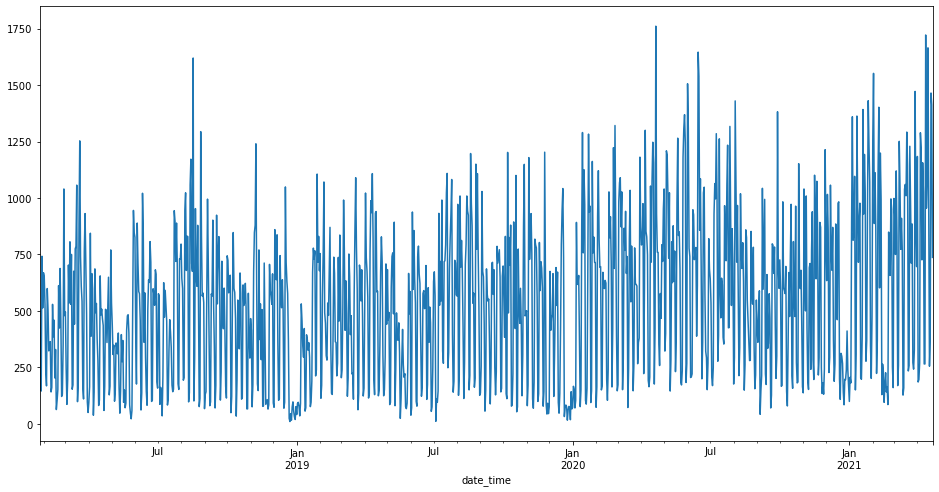

In [17]:
df_java.plot(figsize=(16,8))

In [18]:
df_data = one_program_df_prep(df, 'Data Science')

<AxesSubplot:xlabel='date_time'>

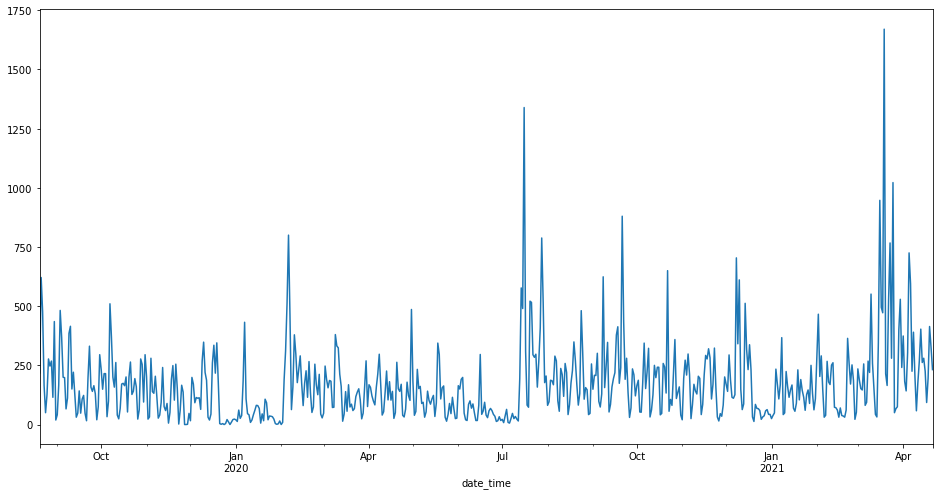

In [19]:
df_data.plot(figsize=(16,8))

In [20]:
df_front = one_program_df_prep(df, 'Front-End')

<AxesSubplot:xlabel='date_time'>

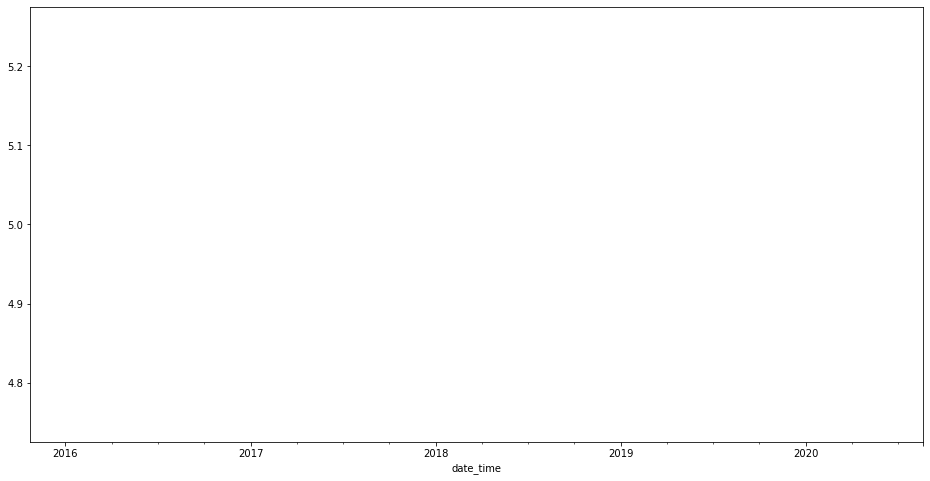

In [21]:
df_front.plot(figsize=(16,8))

Who is accessing the curriculum a lot (total views) and possibiliy looking at lot of unique pages (scraping?)

Aggregate and compute 2 features...number of unique pages and total page views.

In [23]:
df_trial = df[df.name != 'Staff']
df_trial = df_trial[df_trial.path != '/']

In [24]:
page_views = df_trial.groupby(['program', 'name'])['path'].agg(['count', 'nunique'])
page_views

count  nunique
program         name                      
Data Science    Bayes       24571      532
                Curie       19869      417
                Darden      29035      419
                Easley      13600      229
                Florence     7978      161
Front-End       Apollo          4        3
Full-Stack Java Andromeda   24185      365
                Apex        32222      272
                Bash        16941      274
                Betelgeuse  28401      333
                Ceres       39077      300
                Deimos      31421      287
                Europa      26738      266
                Fortuna     34864      257
                Ganymede    32117      295
                Hyperion    28490      269
                Jupiter     35413      287
                Kalypso     22752      272
                Luna        16132      238
                Mammoth       658      231
                Marco       15698      247
                Neptune      6804      135
                Niagara       718      134
                Oberon       1541       47
                Pinnacles    2009      324
                Sequoia      6814      311
                Teddy       29098      543
                Ulysses     26893      405
                Voyageurs   33535      376
                Wrangell    24454      420
                Xanadu      26825      282
                Yosemite    19762      313
                Zion        36298      316
Full-Stack PHP  Arches       8264      341
                Badlands       76       43
                Denali          3        3
                Franklin       68       44
                Glacier       547      142
                Hampton      1502      277
                Ike           234       94
                Joshua        294      116
                Kings        2626      347
                Lassen       9462      485
                Olympic      4705      382
                Quincy       1086      281

In [25]:
page_views = df[df.name != 'Staff'].groupby(['program', 'name'])['path'].agg(['count', 'nunique'])
page_views

count  nunique
program         name                      
Data Science    Bayes       26538      533
                Curie       21581      418
                Darden      32015      420
                Easley      14715      230
                Florence     8562      162
Front-End       Apollo          5        4
Full-Stack Java Andromeda   25359      366
                Apex        33568      273
                Bash        17713      275
                Betelgeuse  29356      334
                Ceres       40730      301
                Deimos      32888      288
                Europa      28033      267
                Fortuna     36902      258
                Ganymede    33844      296
                Hyperion    29855      270
                Jupiter     37109      288
                Kalypso     23691      273
                Luna        16623      239
                Mammoth       691      232
                Marco       16397      248
                Neptune      7276      136
                Niagara       755      135
                Oberon       1672       48
                Pinnacles    2158      325
                Sequoia      7444      312
                Teddy       30926      544
                Ulysses     28534      406
                Voyageurs   35636      377
                Wrangell    25586      421
                Xanadu      27749      283
                Yosemite    20743      314
                Zion        38096      317
Full-Stack PHP  Arches       8890      342
                Badlands       93       44
                Denali          4        4
                Everglades      1        1
                Franklin       72       45
                Glacier       598      143
                Hampton      1712      278
                Ike           253       95
                Joshua        302      117
                Kings        2845      348
                Lassen       9587      486
                Olympic      4954      383
                Quincy       1237      282

# Now lets look at the cohorts specifically

In [26]:
def one_program__cohort_df_prep(df, program_name, cohort):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.program == program_name]
    df = df[df.name != 'Staff']
    df = df[df.name == cohort]
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program_cohort = df['path'].resample('d').count()
    return pages_one_program_cohort

In [27]:
df_data_max = one_program__cohort_df_prep(df, 'Data Science', 'Darden')

<AxesSubplot:xlabel='date_time'>

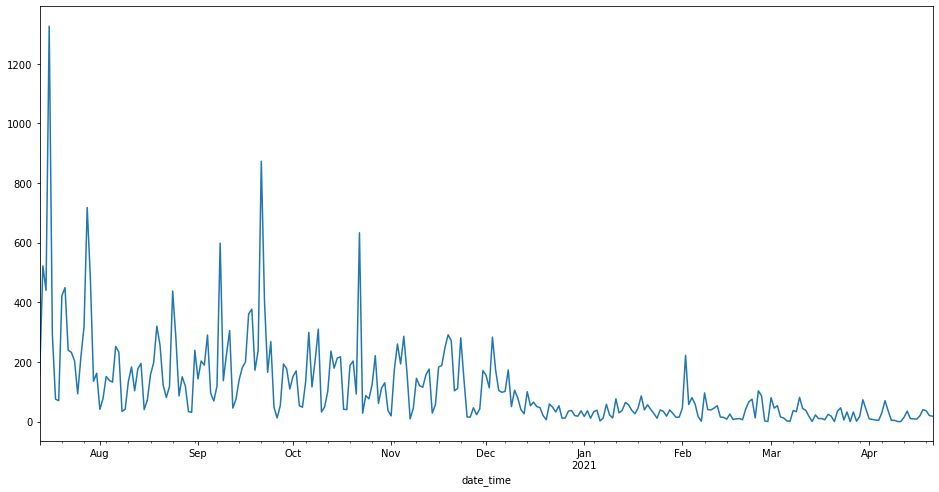

In [28]:
df_data_max.plot(figsize=(16,8))

In [29]:
df_java_max = one_program__cohort_df_prep(df, 'Full-Stack Java', 'Ceres')

<AxesSubplot:xlabel='date_time'>

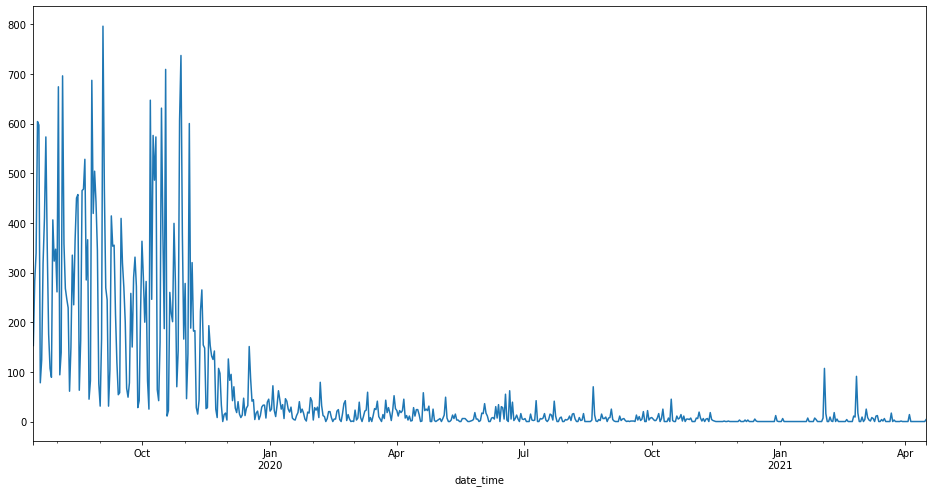

In [30]:
df_java_max.plot(figsize=(16,8))

In [31]:
df_php_max = one_program__cohort_df_prep(df, 'Full-Stack PHP', 'Lassen')

<AxesSubplot:xlabel='date_time'>

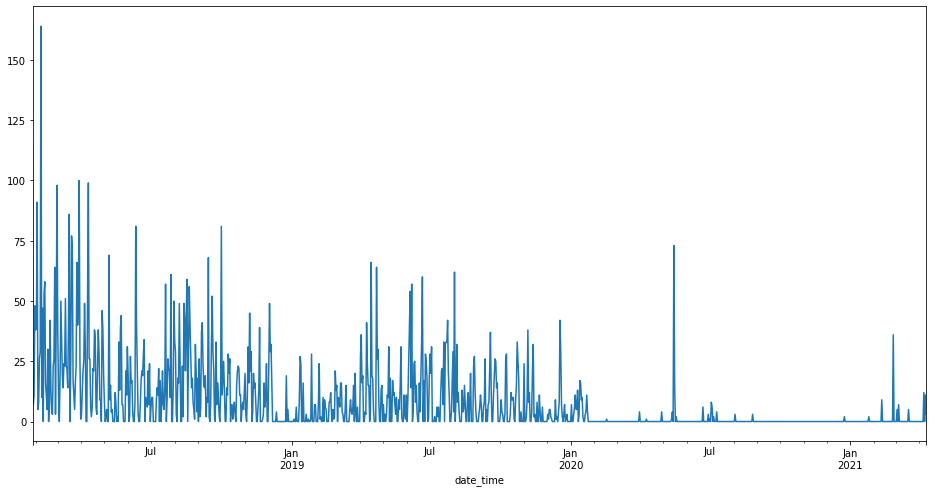

In [32]:
df_php_max.plot(figsize=(16,8))

# Lets look at the biggest classes for a few of the cohorts

In [33]:
df_darden = df[df.name == 'Darden']

In [34]:
df_darden[df_darden.path != '/'].path.value_counts().idxmax()

'classification/overview'

In [35]:
def one_program__cohort_df_prep(df, program_name, cohort):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df['name'].notna()]
    df = df[df.program == program_name]
    df = df[df.name != 'Staff']
    df = df[df.name != 'Everglades']
    df = df[df.name == cohort]
    df = df[df.path != '/']
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program_cohort = df['path'].resample('d').count()
    return pages_one_program_cohort

In [36]:
def biggest_lesson(df, cohort):
    df = df[df.name == cohort]
    df = df[df.path != '/']
    df = df.dropna()
    df_bigget_lesson = df.path.value_counts().idxmax()
    return df_bigget_lesson

In [37]:
for i in list(df[df.name != 'Staff'].name.unique()):
    big_lesson = biggest_lesson(df, i)
    print(big_lesson, ' :', i, '  :', df.program)

java-iii  : Hampton   : date_time
2018-01-26 09:55:03     Full-Stack PHP
2018-01-26 09:56:02     Full-Stack PHP
2018-01-26 09:56:05     Full-Stack PHP
2018-01-26 09:56:06     Full-Stack PHP
2018-01-26 09:56:24    Full-Stack Java
                            ...       
2021-04-21 16:41:51    Full-Stack Java
2021-04-21 16:42:02    Full-Stack Java
2021-04-21 16:42:09    Full-Stack Java
2021-04-21 16:44:37    Full-Stack Java
2021-04-21 16:44:39    Full-Stack Java
Name: program, Length: 900223, dtype: object
spring  : Teddy   : date_time
2018-01-26 09:55:03     Full-Stack PHP
2018-01-26 09:56:02     Full-Stack PHP
2018-01-26 09:56:05     Full-Stack PHP
2018-01-26 09:56:06     Full-Stack PHP
2018-01-26 09:56:24    Full-Stack Java
                            ...       
2021-04-21 16:41:51    Full-Stack Java
2021-04-21 16:42:02    Full-Stack Java
2021-04-21 16:42:09    Full-Stack Java
2021-04-21 16:44:37    Full-Stack Java
2021-04-21 16:44:39    Full-Stack Java
Name: program, Length: 900223, dt

ValueError: attempt to get argmax of an empty sequence

In [38]:
#Front-End
something = biggest_lesson(df, 'Apollo')
something

'content/html-css'

In [39]:
df[df.name != 'nan'].name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', nan, 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Staff',
       'Zion', 'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos',
       'Europa', 'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Everglades',
       'Hyperion', 'Darden', 'Bash', 'Jupiter', 'Kalypso', 'Luna',
       'Easley', 'Marco', 'Neptune', 'Florence', 'Oberon'], dtype=object)

In [40]:
df_new = df[df['name'].notna()]
df_new = df_new[df_new.name != 'Everglades']

In [41]:
df_new.isna().sum()

path          1
user_id       0
cohort_id     0
ip            0
name          0
start_date    0
end_date      0
created_at    0
updated_at    0
program_id    0
program       0
is_staff      0
dtype: int64

In [ ]:
### Finding the largest lesson

In [45]:
def biggest_lesson(df_new, cohort):
    df_new = df_new[df_new.name == cohort]
    df_new = df_new[df_new.path != '/']
    df_new = df_new[df_new.path != 'mkdocs/search_index.json']
    df_new = df_new[df_new.path != 'search/search_index.json']
    df_new = df_new[df_new.path != 'toc']
    df_new = df_new[df_new.path != 'index.html']
    df_new = df_new[df_new.path != 'fundamentals/modern-data-scientist.jpg']
    df_new = df_new[df_new.path != 'fundamentals/AI-ML-DL-timeline.jpg']
    df_new = df_new.dropna()
    #df_new = df_new[df_new.name != 'Everglades']
    df_bigget_lesson = df_new.path.value_counts().idxmax()
    return df_bigget_lesson

In [46]:
df_new[df_new.name != 'Staff'].name.unique()

array(['Hampton', 'Teddy', 'Sequoia', 'Arches', 'Niagara', 'Pinnacles',
       'Quincy', 'Kings', 'Lassen', 'Mammoth', 'Glacier', 'Denali',
       'Joshua', 'Olympic', 'Ulysses', 'Badlands', 'Apollo', 'Ike',
       'Voyageurs', 'Wrangell', 'Xanadu', 'Franklin', 'Yosemite', 'Zion',
       'Andromeda', 'Betelgeuse', 'Ceres', 'Bayes', 'Deimos', 'Europa',
       'Fortuna', 'Curie', 'Apex', 'Ganymede', 'Hyperion', 'Darden',
       'Bash', 'Jupiter', 'Kalypso', 'Luna', 'Easley', 'Marco', 'Neptune',
       'Florence', 'Oberon'], dtype=object)

# This answe4rs the question

In [47]:
df_lessons = pd.DataFrame()
programs_list = []
lesson_list = []
cohort_list = []

In [48]:
for i in list(df_new[df_new.name != 'Staff'].name.unique()):
    big_lesson = biggest_lesson(df_new, i)
    print(big_lesson, ' :', i, ' :' ,df_new[df_new.name == i].program.unique())
    print('-----------------------------------')
    programs_list.extend(df_new[df_new.name == i].program.unique())
    lesson_list.append(big_lesson)
    cohort_list.append(i)
    

java-iii  : Hampton  : ['Full-Stack PHP']
-----------------------------------
spring  : Teddy  : ['Full-Stack Java']
-----------------------------------
spring  : Sequoia  : ['Full-Stack Java']
-----------------------------------
javascript-i  : Arches  : ['Full-Stack PHP']
-----------------------------------
spring  : Niagara  : ['Full-Stack Java']
-----------------------------------
javascript-i  : Pinnacles  : ['Full-Stack Java']
-----------------------------------
content/laravel/intro  : Quincy  : ['Full-Stack PHP']
-----------------------------------
content/laravel/intro  : Kings  : ['Full-Stack PHP']
-----------------------------------
javascript-i  : Lassen  : ['Full-Stack PHP']
-----------------------------------
java-i  : Mammoth  : ['Full-Stack Java']
-----------------------------------
content/html-css  : Glacier  : ['Full-Stack PHP']
-----------------------------------
prework/versioning/github  : Denali  : ['Full-Stack PHP']
-----------------------------------
content/ht

In [49]:
df_lessons = pd.DataFrame(
    {'Lesson': lesson_list,
     'Cohort': cohort_list,
     'Program': programs_list
    })

df_lessons.head()

,Lesson,Cohort,Program
0,java-iii,Hampton,Full-Stack PHP
1,spring,Teddy,Full-Stack Java
2,spring,Sequoia,Full-Stack Java
3,javascript-i,Arches,Full-Stack PHP
4,spring,Niagara,Full-Stack Java


# Answer Answer

In [50]:
df_lessons.groupby(['Program', 'Cohort']).Lesson.max()

Program          Cohort    
Data Science     Bayes                  1-fundamentals/modern-data-scientist.jpg
                 Curie                                   6-regression/1-overview
                 Darden                                  classification/overview
                 Easley                 classification/scale_features_or_not.svg
                 Florence                     fundamentals/intro-to-data-science
Front-End        Apollo                                         content/html-css
Full-Stack Java  Andromeda                                          javascript-i
                 Apex                                                   html-css
                 Bash                                               javascript-i
                 Betelgeuse                                         javascript-i
                 Ceres                                              javascript-i
                 Deimos                                             javascript-i


In [51]:
df_lessons.groupby('Program').Lesson.max()

Program
Data Science       fundamentals/intro-to-data-science
Front-End                            content/html-css
Full-Stack Java                                spring
Full-Stack PHP              prework/versioning/github
Name: Lesson, dtype: object

In [ ]:
def one_program__cohort_df_prep(df, program_name, cohort):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df['name'].notna()]
    df = df[df.program == program_name]
    df = df[df.name != 'Staff']
    df = df[df.name != 'Everglades']
    df = df[df.name == cohort]
    df = df[df.path != '/']
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program_cohort = df['path'].resample('d').count()
    return pages_one_program_cohort

# Lets look at dbscan of some unique paths

In [226]:
page_views = df_new[df_new.name != 'Staff'].groupby(['program', 'name'])['path'].agg(['count', 'nunique'])
page_views

count  nunique
program         name                      
Data Science    Bayes       26538      533
                Curie       21581      418
                Darden      32015      420
                Easley      14715      230
                Florence     8562      162
Front-End       Apollo          5        4
Full-Stack Java Andromeda   25359      366
                Apex        33568      273
                Bash        17713      275
                Betelgeuse  29356      334
                Ceres       40730      301
                Deimos      32888      288
                Europa      28033      267
                Fortuna     36902      258
                Ganymede    33844      296
                Hyperion    29855      270
                Jupiter     37109      288
                Kalypso     23691      273
                Luna        16623      239
                Mammoth       691      232
                Marco       16397      248
                Neptune      7276      136
                Niagara       755      135
                Oberon       1672       48
                Pinnacles    2158      325
                Sequoia      7444      312
                Teddy       30926      544
                Ulysses     28534      406
                Voyageurs   35636      377
                Wrangell    25586      421
                Xanadu      27749      283
                Yosemite    20743      314
                Zion        38096      317
Full-Stack PHP  Arches       8890      342
                Badlands       93       44
                Denali          4        4
                Franklin       72       45
                Glacier       598      143
                Hampton      1712      278
                Ike           253       95
                Joshua        302      117
                Kings        2845      348
                Lassen       9587      486
                Olympic      4954      383
                Quincy       1237      282

In [212]:
# create the scaler
scaler = MinMaxScaler().fit(page_views)
# use the scaler
page_views_scaled_array = scaler.transform(page_views)
page_views_scaled_array[0:10]

array([[6.51524824e-01, 9.79629630e-01],
       [5.29808967e-01, 7.66666667e-01],
       [7.86008938e-01, 7.70370370e-01],
       [3.61218877e-01, 4.18518519e-01],
       [2.10136031e-01, 2.92592593e-01],
       [2.45543388e-05, 0.00000000e+00],
       [6.22575259e-01, 6.70370370e-01],
       [8.24141826e-01, 4.98148148e-01],
       [4.34832785e-01, 5.01851852e-01],
       [7.20718951e-01, 6.11111111e-01]])

In [213]:
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(page_views_scaled_array)
print(dbsc)

DBSCAN(eps=0.1, min_samples=4)


In [214]:
# Now, let's add the scaled value columns back onto the dataframe

columns = list(page_views.columns)
scaled_columns = ["scaled_" + column for column in columns]
scaled_columns

['scaled_count', 'scaled_nunique']

In [215]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(page_views_scaled_array, columns=scaled_columns, index=page_views.index)
scaled_df.head()

scaled_count  scaled_nunique
program      name                                  
Data Science Bayes         0.651525        0.979630
             Curie         0.529809        0.766667
             Darden        0.786009        0.770370
             Easley        0.361219        0.418519
             Florence      0.210136        0.292593

In [216]:
# Merge the scaled and non-scaled values into one dataframe
page_views = page_views.merge(scaled_df, left_index=True, right_index=True)
page_views

count  nunique  scaled_count  scaled_nunique
program         name                                                    
Data Science    Bayes       26538      533      0.651525        0.979630
                Curie       21581      418      0.529809        0.766667
                Darden      32015      420      0.786009        0.770370
                Easley      14715      230      0.361219        0.418519
                Florence     8562      162      0.210136        0.292593
Front-End       Apollo          5        4      0.000025        0.000000
Full-Stack Java Andromeda   25359      366      0.622575        0.670370
                Apex        33568      273      0.824142        0.498148
                Bash        17713      275      0.434833        0.501852
                Betelgeuse  29356      334      0.720719        0.611111
                Ceres       40730      301      1.000000        0.550000
                Deimos      32888      288      0.807445        0.525926
                Europa      28033      267      0.688234        0.487037
                Fortuna     36902      258      0.906006        0.470370
                Ganymede    33844      296      0.830919        0.540741
                Hyperion    29855      270      0.732972        0.492593
                Jupiter     37109      288      0.911089        0.525926
                Kalypso     23691      273      0.581619        0.498148
                Luna        16623      239      0.408069        0.435185
                Mammoth       691      232      0.016869        0.422222
                Marco       16397      248      0.402519        0.451852
                Neptune      7276      136      0.178559        0.244444
                Niagara       755      135      0.018440        0.242593
                Oberon       1672       48      0.040957        0.081481
                Pinnacles    2158      325      0.052890        0.594444
                Sequoia      7444      312      0.182684        0.570370
                Teddy       30926      544      0.759269        1.000000
                Ulysses     28534      406      0.700535        0.744444
                Voyageurs   35636      377      0.874920        0.690741
                Wrangell    25586      421      0.628149        0.772222
                Xanadu      27749      283      0.681260        0.516667
                Yosemite    20743      314      0.509232        0.574074
                Zion        38096      317      0.935324        0.579630
Full-Stack PHP  Arches       8890      342      0.218190        0.625926
                Badlands       93       44      0.002185        0.074074
                Denali          4        4      0.000000        0.000000
                Franklin       72       45      0.001670        0.075926
                Glacier       598      143      0.014585        0.257407
                Hampton      1712      278      0.041939        0.507407
                Ike           253       95      0.006114        0.168519
                Joshua        302      117      0.007317        0.209259
                Kings        2845      348      0.069759        0.637037
                Lassen       9587      486      0.235304        0.892593
                Olympic      4954      383      0.121544        0.701852
                Quincy       1237      282      0.030275        0.514815

In [217]:
labels = dbsc.labels_
labels[0:15]

array([-1, -1, -1,  2, -1,  0, -1,  1,  2, -1,  1,  1,  1,  1,  1])

In [218]:
#add labels back to the dataframe
page_views['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views.labels.value_counts()

-1    17
 1    10
 0     9
 3     5
 2     4
Name: labels, dtype: int64

In [223]:
page_views[page_views.labels==3]

count  nunique  scaled_count  scaled_nunique  \
program         name                                                      
Full-Stack Java Mammoth      691      232      0.016869        0.422222   
                Pinnacles   2158      325      0.052890        0.594444   
Full-Stack PHP  Hampton     1712      278      0.041939        0.507407   
                Kings       2845      348      0.069759        0.637037   
                Quincy      1237      282      0.030275        0.514815   

                           labels  
program         name               
Full-Stack Java Mammoth         3  
                Pinnacles       3  
Full-Stack PHP  Hampton         3  
                Kings           3  
                Quincy          3

In [224]:
page_views[page_views.labels==2]

count  nunique  scaled_count  scaled_nunique  labels
program         name                                                        
Data Science    Easley  14715      230      0.361219        0.418519       2
Full-Stack Java Bash    17713      275      0.434833        0.501852       2
                Luna    16623      239      0.408069        0.435185       2
                Marco   16397      248      0.402519        0.451852       2

In [219]:
page_views[page_views.labels==1]

count  nunique  scaled_count  scaled_nunique  labels
program         name                                                          
Full-Stack Java Apex      33568      273      0.824142        0.498148       1
                Ceres     40730      301      1.000000        0.550000       1
                Deimos    32888      288      0.807445        0.525926       1
                Europa    28033      267      0.688234        0.487037       1
                Fortuna   36902      258      0.906006        0.470370       1
                Ganymede  33844      296      0.830919        0.540741       1
                Hyperion  29855      270      0.732972        0.492593       1
                Jupiter   37109      288      0.911089        0.525926       1
                Xanadu    27749      283      0.681260        0.516667       1
                Zion      38096      317      0.935324        0.579630       1

In [220]:
page_views[page_views.labels==0]

count  nunique  scaled_count  scaled_nunique  labels
program         name                                                          
Front-End       Apollo        5        4      0.000025        0.000000       0
Full-Stack Java Niagara     755      135      0.018440        0.242593       0
                Oberon     1672       48      0.040957        0.081481       0
Full-Stack PHP  Badlands     93       44      0.002185        0.074074       0
                Denali        4        4      0.000000        0.000000       0
                Franklin     72       45      0.001670        0.075926       0
                Glacier     598      143      0.014585        0.257407       0
                Ike         253       95      0.006114        0.168519       0
                Joshua      302      117      0.007317        0.209259       0

#### label '-1' represents observations which are not part of any cluster and are potential anomalies warranting further investigation

In [221]:
page_views[page_views.labels==-1]

count  nunique  scaled_count  scaled_nunique  \
program         name                                                       
Data Science    Bayes       26538      533      0.651525        0.979630   
                Curie       21581      418      0.529809        0.766667   
                Darden      32015      420      0.786009        0.770370   
                Florence     8562      162      0.210136        0.292593   
Full-Stack Java Andromeda   25359      366      0.622575        0.670370   
                Betelgeuse  29356      334      0.720719        0.611111   
                Kalypso     23691      273      0.581619        0.498148   
                Neptune      7276      136      0.178559        0.244444   
                Sequoia      7444      312      0.182684        0.570370   
                Teddy       30926      544      0.759269        1.000000   
                Ulysses     28534      406      0.700535        0.744444   
                Voyageurs   35636      377      0.874920        0.690741   
                Wrangell    25586      421      0.628149        0.772222   
                Yosemite    20743      314      0.509232        0.574074   
Full-Stack PHP  Arches       8890      342      0.218190        0.625926   
                Lassen       9587      486      0.235304        0.892593   
                Olympic      4954      383      0.121544        0.701852   

                            labels  
program         name                
Data Science    Bayes           -1  
                Curie           -1  
                Darden          -1  
                Florence        -1  
Full-Stack Java Andromeda       -1  
                Betelgeuse      -1  
                Kalypso         -1  
                Neptune         -1  
                Sequoia         -1  
                Teddy           -1  
                Ulysses         -1  
                Voyageurs       -1  
                Wrangell        -1  
                Yosemite        -1  
Full-Stack PHP  Arches          -1  
                Lassen          -1  
                Olympic         -1

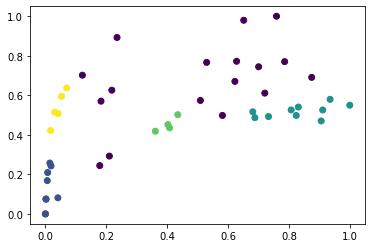

In [222]:
plt.scatter(page_views['scaled_count'], page_views['scaled_nunique'], c=page_views.labels)
plt.show()

We will accomplish this by breaking down to the following tasks:

1) Make the analysis process (which we will discuss later) work over all users.

2) Turn the analysis process and calculations into a function that can be used to loop through for each user.

3) Test the function on a single user.

4) Analyze by looping over all users.

---------------------
The analysis process will look like this, for each user:

1) Compute necessary metrics to arrive at the final metric, %b (percent-b).

2) Add user id to the dataframe that contains all the metrics, including %b.

3) Filter to rows where %b indicates anomaly (i.e. > 1)

4) Append rows of anomalies of new user to previous users' anomalous activity.

## 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [ ]:
# students == user_id
# active == ?
# curriculum access? low page count?
# info as in what cohorts? what programs specifically have a low access amount?

In [227]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False


In [228]:
# active is times start_date between end_date == active
df['active'] = df.index < df.end_date

In [229]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,active
date_time,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,True


In [233]:
# get only active dataframe
df_active = df[df.active == True]

In [234]:
df_active

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,active
date_time,,,,,,,,,,,,,
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,True
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,True
2018-01-26 09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,True
2018-01-26 09:56:48,javascript-i/functions,3,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,True
2018-01-26 09:56:59,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:36:09,jquery/personal-site,869,135.0,136.50.98.51,Marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,2.0,Full-Stack Java,False,True
2021-04-21 16:36:34,html-css/css-ii/bootstrap-grid-system,948,138.0,104.48.214.211,Neptune,2021-03-15,2021-09-03,2021-03-15 19:57:09,2021-03-15 19:57:09,2.0,Full-Stack Java,False,True
2021-04-21 16:37:48,java-iii,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2020-12-07 16:58:43,2020-12-07 16:58:43,2.0,Full-Stack Java,False,True


In [235]:
# curriculum access? low page count? (lower bound)
# info as in what cohorts? what programs specifically have a low access amount?

In [270]:

pages = df_active['path'].resample('d').count()
pages.head()

date_time
2018-01-26    496
2018-01-27    188
2018-01-28    145
2018-01-29    725
2018-01-30    488
Freq: D, Name: path, dtype: int64

In [271]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date_time
2018-01-26    496.000000
2018-01-27    336.866667
2018-01-28    268.601629
2018-01-29    394.356012
2018-01-30    415.662286
Freq: D, Name: path, dtype: float64

In [272]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()


date_time
2018-01-26           NaN
2018-01-27    217.788889
2018-01-28    188.681591
2018-01-29    280.137252
2018-01-30    242.455115
Freq: D, Name: path, dtype: float64

In [273]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub, lb

(date_time
 2018-01-26            NaN
 2018-01-27     990.233332
 2018-01-28     834.646401
 2018-01-29    1234.767767
 2018-01-30    1143.027631
                  ...     
 2021-04-17    2654.951328
 2021-04-18    2610.586532
 2021-04-19    2694.818748
 2021-04-20    2708.799354
 2021-04-21    2647.648123
 Freq: D, Name: path, Length: 1182, dtype: float64,
 date_time
 2018-01-26           NaN
 2018-01-27   -316.499999
 2018-01-28   -297.443143
 2018-01-29   -446.055743
 2018-01-30   -311.703058
                  ...    
 2021-04-17   -690.681583
 2021-04-18   -710.721288
 2021-04-19   -700.364164
 2021-04-20   -652.567647
 2021-04-21   -615.560397
 Freq: D, Name: path, Length: 1182, dtype: float64)

In [274]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date_time,,
2018-01-26,NaN,NaN
2018-01-27,990.233332,-316.499999
2018-01-28,834.646401,-297.443143
2018-01-29,1234.767767,-446.055743
2018-01-30,1143.027631,-311.703058


In [275]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date_time,,,,
2018-01-26,496,496.000000,NaN,NaN
2018-01-27,188,336.866667,990.233332,-316.499999
2018-01-28,145,268.601629,834.646401,-297.443143
2018-01-29,725,394.356012,1234.767767,-446.055743
2018-01-30,488,415.662286,1143.027631,-311.703058


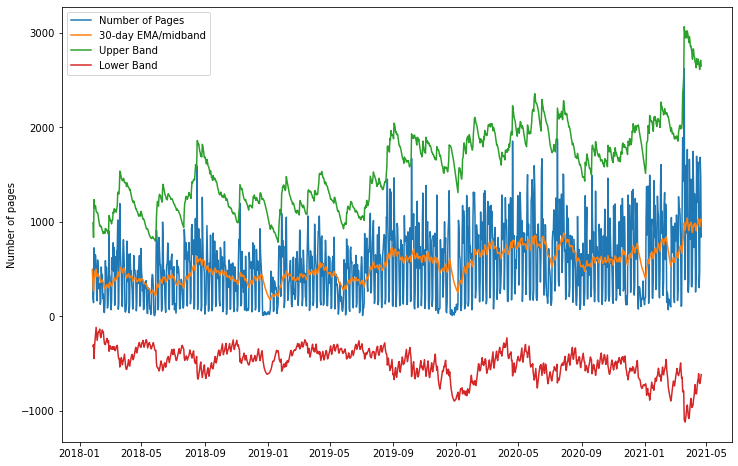

In [276]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [290]:
def one_user_df_prep(df_active, user):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df_active = df_active[df_active.user_id == user]
    #df = df[df.program == program] #'data_science'
    #df_active.date = pd.to_datetime(df.date)
    #df_active = df_active.set_index(df.date)
    pages_one_user = df_active['path'].resample('d').count()
    return pages_one_user

def compute_pct_b(pages_one_user, span, weight, user):
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    # Calculate upper and lower bollinger band
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    #program = pages_one_user[pages_one_user.user_id == user].program.unique()
    
    # Add upper and lower band values to dataframe
    bb = pd.concat([ub, lb], axis=1)
    
    # Combine all data into a single dataframe
    my_df = pd.concat([pages_one_user, midband, bb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    # Calculate percent b and relevant user id to dataframe
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    #my_df['program'] = program
    return my_df

def plot_bands(my_df, user):
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df_active, user, span, weight, plot=False):
    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''
    
    # Reduce dataframe to represent a single user
    pages_one_user = one_user_df_prep(df_active, user)
    
    # Add bollinger band data to dataframe
    my_df = compute_pct_b(pages_one_user, span, weight, user)
    
    # Plot data if requested (plot=True)
    if plot:
        plot_bands(my_df, user)
    
    # Return only records that sit outside of bollinger band upper limit
    return my_df[my_df.pct_b>1]

In [291]:
# Lets look throughall usesr
span = 30
weight = 3.5

anomalies_active = pd.DataFrame()
for u in list(df_active.user_id.unique()):
    user_df = find_anomalies(df_active, u, span, weight)
    anomalies_active = pd.concat([anomalies_active, user_df], axis=0)

In [292]:
anomalies_active

,pages_one_user,midband,ub,lb,pct_b,user_id
date_time,,,,,,
2020-01-13,6,0.387097,5.634365,-4.860171,1.034841,120
2018-07-02,11,0.722386,10.483319,-9.038548,1.026467,130
2018-07-03,34,2.870000,33.470043,-27.730042,1.008659,130
2020-07-13,1,0.064516,0.939061,-0.810028,1.034841,268
2020-07-14,15,1.028096,14.117203,-12.061011,1.033723,268
2020-07-16,78,6.595867,74.984500,-61.792766,1.022047,268
2020-09-21,78,9.904284,77.797194,-57.988626,1.001494,268
2019-02-19,67,7.917536,65.748729,-49.913656,1.010818,305
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341


In [282]:
anomalies_active.sort_values(by='lb', ascending=True)

,pages_one_user,midband,ub,lb,pct_b,user_id
date_time,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2019-12-19,192,19.601776,187.231096,-148.027544,1.014225,526
2020-10-16,179,20.158062,173.720239,-133.404115,1.017191,658
2019-12-20,116,13.377302,113.144166,-86.389563,1.014313,482
2020-05-26,113,14.031224,111.641207,-83.578760,1.006960,635
2021-02-01,101,11.357678,100.834937,-78.119582,1.000922,750
2020-08-03,99,10.952041,96.329625,-74.425543,1.015639,664
2020-07-09,95,10.983019,93.187723,-71.221684,1.011023,643
2020-04-16,93,10.343778,91.138156,-70.450600,1.011522,560


In [293]:
df_341 = one_user_df_prep(df, 341)

<AxesSubplot:xlabel='date_time'>

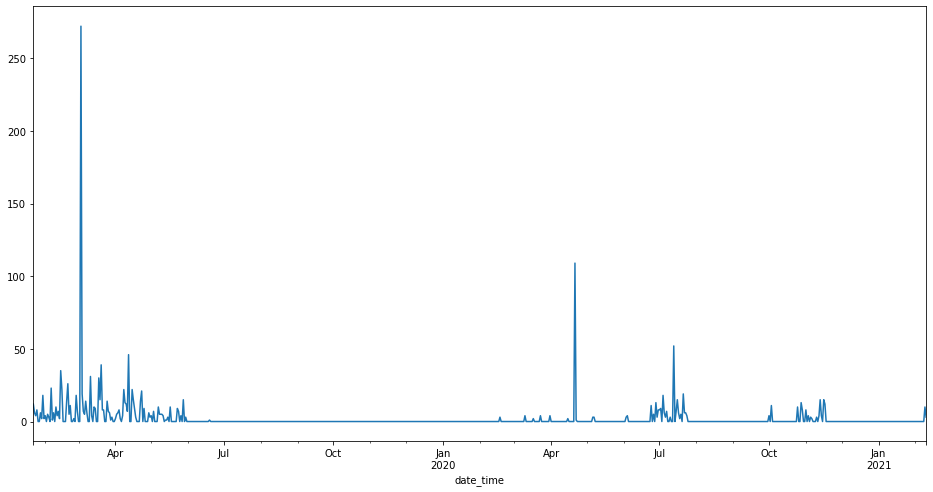

In [295]:
df_341.plot(figsize=(16,8))

<AxesSubplot:xlabel='date_time'>

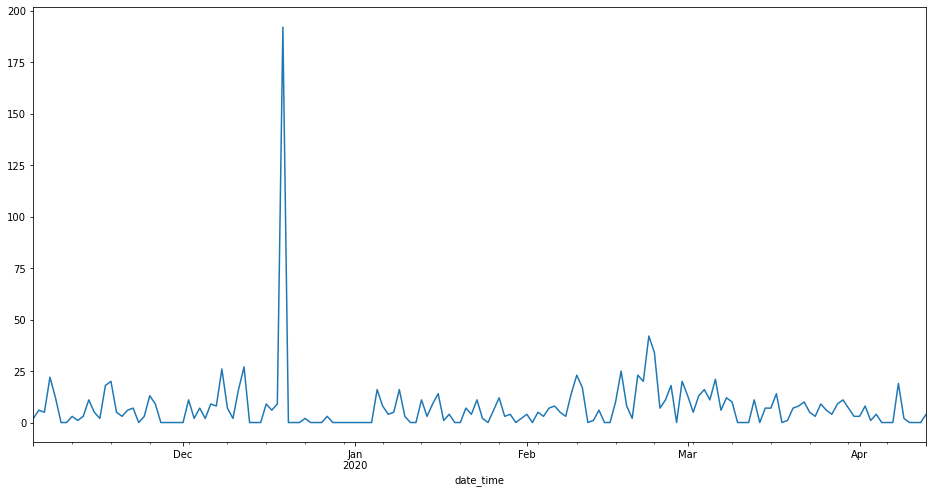

In [296]:

df_526 = one_user_df_prep(df, 526)
df_526.plot(figsize=(16,8))

# 6)  What topics are grads continuing to reference after graduation and into their jobs (for each program)?


In [ ]:
# grads definded? after end_date
# 

In [52]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff
date_time,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False


In [53]:
df['is_grad'] = df.index > df.end_date

In [54]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,is_grad
date_time,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,False


In [55]:
df_grad = df[df.is_grad == True]
df_grad.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,is_grad
date_time,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 10:14:47,/,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True


In [56]:
# What topics are they referenceing? main paths per program

In [57]:
df_grad = df_grad[df_grad['path'] != '/']
df_grad.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,is_grad
date_time,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,True


In [58]:
page_views_grad = df_grad[df_grad.name != 'Staff'].groupby(['program'])['path'].agg(['count', 'nunique'])
page_views_grad

,count,nunique
program,,
Data Science,10098,436
Front-End,4,3
Full-Stack Java,67904,819
Full-Stack PHP,28867,709


In [64]:
def biggest_lesson_grad(df_grad, program):
    df_grad = df_grad[df_grad.program == program]
    
    df_grad = df_grad[df_grad.path != 'mkdocs/search_index.json']
    df_grad = df_grad[df_grad.path != 'search/search_index.json']
    df_grad = df_grad[df_grad.path != 'toc']
    df_grad = df_grad[df_grad.path != 'index.html']
    df_grad = df_grad[df_grad.path != 'fundamentals/modern-data-scientist.jpg']
    df_grad = df_grad[df_grad.path != 'fundamentals/AI-ML-DL-timeline.jpg']
    
    df_grad = df_grad.dropna()
    #df_new = df_new[df_new.name != 'Everglades']
    df_bigget_lesson_grad = df_grad.path.value_counts().idxmax()
    return df_bigget_lesson_grad

In [60]:
df_grad.path.value_counts()

javascript-i                               4969
spring                                     4273
search/search_index.json                   4183
html-css                                   3687
java-iii                                   3541
                                           ... 
content/mysql/intro-to-mysql/index.html       1
j                                             1
javascript-functions                          1
content/examples/php/arithmetic.php           1
interview-questions                           1
Name: path, Length: 1864, dtype: int64

In [65]:
for i in list(df_grad.program.unique()):
    big_lesson_grad = biggest_lesson_grad(df_grad, i)
    print(big_lesson_grad, ' :', i)
    print('-----------------------------------')
    #programs_list.extend(df_new[df_new.name == i].program.unique())
    #lesson_list.append(big_lesson)
    #cohort_list.append(i)

javascript-i  : Full-Stack PHP
-----------------------------------
javascript-i  : Full-Stack Java
-----------------------------------
content/html-css  : Front-End
-----------------------------------
sql/mysql-overview  : Data Science
-----------------------------------


In [66]:
for i in list(df_grad.program.unique()):
    big_lesson_grad = biggest_lesson_grad(df_grad, i)
    print(big_lesson_grad, ' :', i, ' :' ,df_grad[df_grad.program == i].name.unique())
    print('-----------------------------------')
    #programs_list.extend(df_grad[df_grad.name == i].program.unique())
    #lesson_list.append(big_lesson)
    #cohort_list.append(i)
    

javascript-i  : Full-Stack PHP  : ['Hampton' 'Arches' 'Quincy' 'Kings' 'Lassen' 'Glacier' 'Denali' 'Joshua'
 'Olympic' 'Badlands' 'Ike' 'Franklin']
-----------------------------------
javascript-i  : Full-Stack Java  : ['Niagara' 'Pinnacles' 'Mammoth' 'Sequoia' 'Teddy' 'Ulysses' 'Voyageurs'
 'Wrangell' 'Staff' 'Xanadu' 'Yosemite' 'Zion' 'Andromeda' 'Betelgeuse'
 'Ceres' 'Deimos' 'Europa' 'Fortuna' 'Apex' 'Ganymede' 'Hyperion' 'Bash'
 'Jupiter']
-----------------------------------
content/html-css  : Front-End  : ['Apollo']
-----------------------------------
sql/mysql-overview  : Data Science  : ['Bayes' 'Curie' 'Darden']
-----------------------------------


### Lets look at grad cohort progams specifically

In [73]:
def one_program__cohort_df_grad_prep(df, program_name, cohort):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.program == program_name]
    #df = df[df.name != 'Staff']
    df = df[df.name == cohort]
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program_cohort_grad = df['path'].resample('d').count()
    return pages_one_program_cohort_grad

<AxesSubplot:xlabel='date_time'>

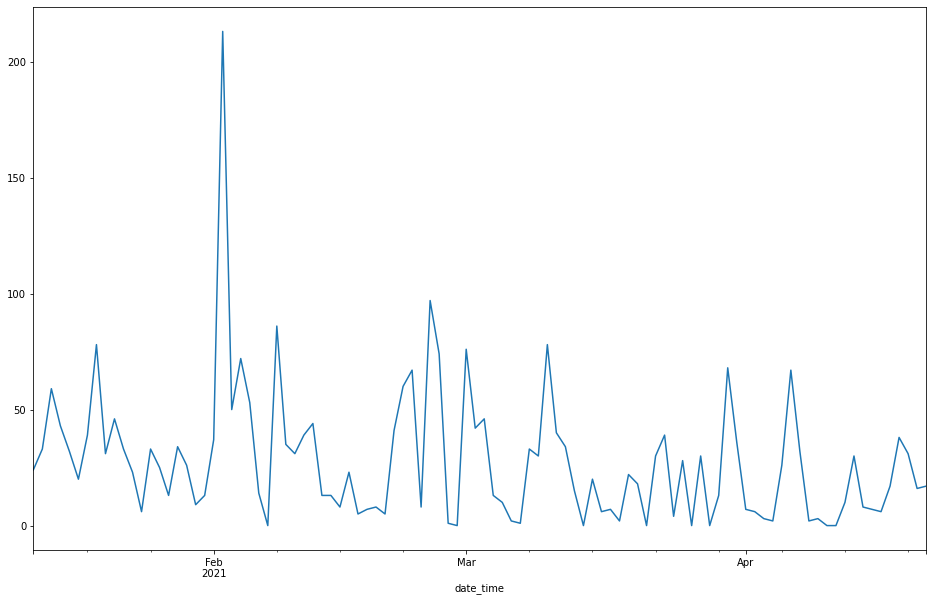

In [74]:
df_data_max_grad = one_program__cohort_df_grad_prep(df_grad, 'Data Science', 'Darden')
df_data_max_grad.plot(figsize=(16,10))

<AxesSubplot:xlabel='date_time'>

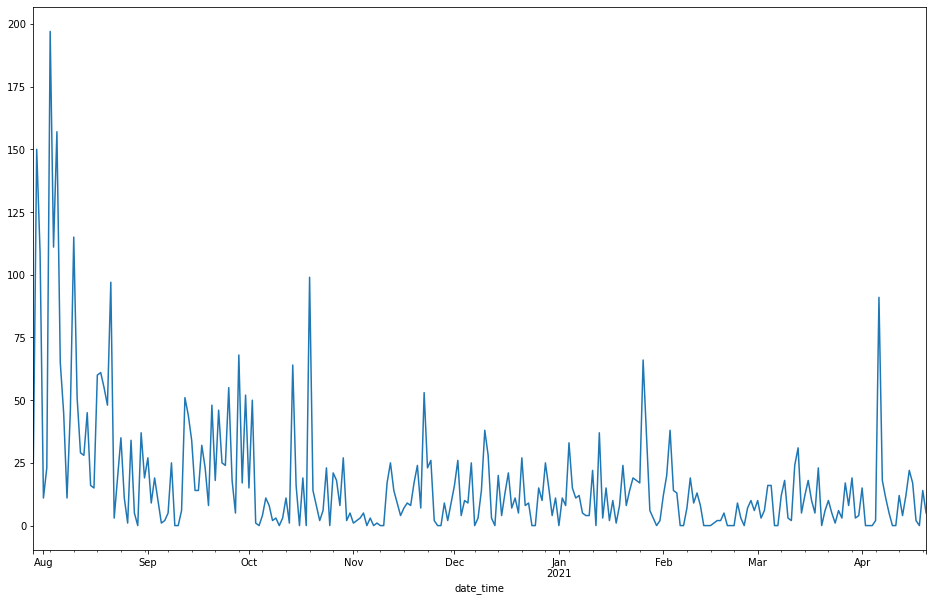

In [76]:
df_java_max_grad = one_program__cohort_df_grad_prep(df_grad, 'Full-Stack Java', 'Apex')
df_java_max_grad.plot(figsize=(16,10))

<AxesSubplot:xlabel='date_time'>

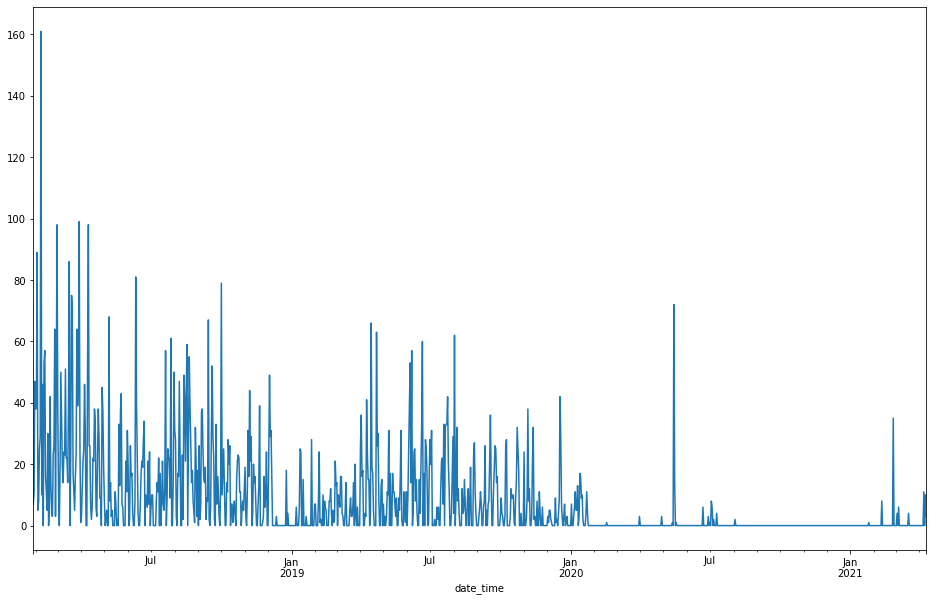

In [77]:
df_php_max_grad = one_program__cohort_df_grad_prep(df_grad, 'Full-Stack PHP', 'Lassen')
df_php_max_grad.plot(figsize=(16,10))

# 3) is there any suspicous activity such as users accessing the curriculum who shouldnt be? Does it appear that any web_scraping is happening? are there any suspicous IP addresses?

In [312]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,active,is_grad
date_time,,,,,,,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2.0,Full-Stack Java,False,True,False


### LEts look at users using dbscan for any anomalies

In [313]:
page_views_anomaly = df.groupby(['user_id'])['path'].agg(['count', 'nunique'])
page_views_anomaly

,count,nunique
user_id,,
1,7404,976
2,1541,151
3,1562,169
4,692,143
5,1701,197
...,...,...
977,86,12
978,55,18
979,127,20


In [314]:
# create the scaler
scaler = MinMaxScaler().fit(page_views_anomaly)
# use the scaler
page_views__anomaly_scaled_array = scaler.transform(page_views_anomaly)
page_views__anomaly_scaled_array[0:10]

array([[0.41329835, 1.        ],
       [0.08597588, 0.15384615],
       [0.08714828, 0.17230769],
       [0.03857749, 0.14564103],
       [0.09490844, 0.20102564],
       [0.07855069, 0.22974359],
       [0.10060295, 0.17435897],
       [0.02690933, 0.09128205],
       [0.03260384, 0.14871795],
       [0.05141804, 0.14666667]])

In [315]:
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(page_views__anomaly_scaled_array)

In [317]:
columns = list(page_views_anomaly.columns)
scaled_columns = ["scaled_" + column for column in columns]

In [318]:
scaled_df = pd.DataFrame(page_views__anomaly_scaled_array, columns=scaled_columns, index=page_views_anomaly.index)

In [319]:
# Merge the scaled and non-scaled values into one dataframe
page_views_anomaly = page_views_anomaly.merge(scaled_df, left_index=True, right_index=True)


In [320]:
labels = dbsc.labels_

In [321]:
#add labels back to the dataframe
page_views_anomaly['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views_anomaly.labels.value_counts()

 0    976
-1      5
Name: labels, dtype: int64

In [323]:
page_views_anomaly[page_views_anomaly.labels==-1]

,count,nunique,scaled_count,scaled_nunique,labels
user_id,,,,,
1,7404,976,0.413298,1.000000,-1
11,17913,871,1.000000,0.892308,-1
53,12329,333,0.688254,0.340513,-1
64,16347,437,0.912573,0.447179,-1
248,5075,625,0.283274,0.640000,-1


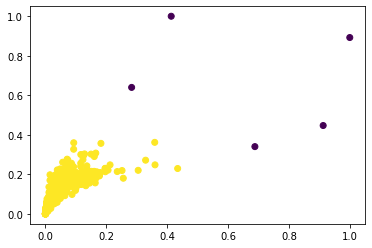

In [322]:
plt.scatter(page_views_anomaly['scaled_count'], page_views_anomaly['scaled_nunique'], c=page_views_anomaly.labels)
plt.show()

### Now lets look at the ip using dbscan to see any anomalies

In [324]:
page_views_ip = df.groupby(['ip', 'user_id'])['path'].agg(['count', 'nunique'])
page_views_ip

,,count,nunique
ip,user_id,,
100.11.170.135,658,114,20
100.19.73.35,658,408,57
100.35.67.162,52,11,8
103.137.12.164,469,9,8
103.208.220.130,369,1,1
...,...,...,...
99.97.210.12,606,18,12
99.98.245.245,618,2,2
99.98.32.165,324,267,101


In [325]:
# create the scaler
scaler = MinMaxScaler().fit(page_views_ip)
# use the scaler
page_views_ip_scaled_array = scaler.transform(page_views_ip)
#######
dbsc = DBSCAN(eps = 0.1, min_samples=4).fit(page_views_ip_scaled_array)

columns = list(page_views_ip.columns)
scaled_columns = ["scaled_" + column for column in columns]

scaled_df = pd.DataFrame(page_views_ip_scaled_array, columns=scaled_columns, index=page_views_ip.index)


# Merge the scaled and non-scaled values into one dataframe
page_views_ip = page_views_ip.merge(scaled_df, left_index=True, right_index=True)

labels = dbsc.labels_

#add labels back to the dataframe
page_views_ip['labels'] = labels

# how many unique labels (clusters) are created by DBSCAN?
page_views_ip.labels.value_counts()

 0    7526
-1       9
Name: labels, dtype: int64

In [326]:
page_views_ip[page_views_ip.labels==-1]

count  nunique  scaled_count  scaled_nunique  labels
ip             user_id                                                      
71.150.217.33  64        6790      290      0.963252        0.479270      -1
76.185.131.226 11        2618      436      0.371311        0.721393      -1
76.185.145.231 11        4754      336      0.674376        0.555556      -1
97.105.19.58   1         3099      604      0.439557        1.000000      -1
               11        7049      590      1.000000        0.976783      -1
               53        4895      224      0.694381        0.369818      -1
               64        5690      250      0.807179        0.412935      -1
               248       2231      415      0.316402        0.686567      -1
               404       1293      306      0.183314        0.505804      -1

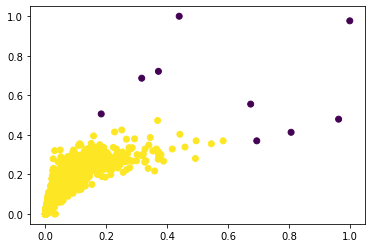

In [327]:
plt.scatter(page_views_ip['scaled_count'], page_views_ip['scaled_nunique'], c=page_views_ip.labels)
plt.show()

In [335]:
df[df.user_id == 404]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,active,is_grad
date_time,,,,,,,,,,,,,,
2019-05-09 10:45:33,/,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2019-05-09 11:02:41,ada-python-assessment.html,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2019-05-09 14:14:02,git,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2019-05-09 14:49:48,git,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2019-05-09 15:04:36,open_data,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-25 15:51:02,/,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2019-11-25 15:51:06,10-anomaly-detection/1-overview,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2019-11-25 15:51:06,10-anomaly-detection/AnomalyDetectionCartoon.jpeg,404,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True


In [333]:
df[df.user_id == 11]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,active,is_grad
date_time,,,,,,,,,,,,,,
2018-01-26 10:14:47,/,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 10:14:51,javascript-i,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 10:15:02,javascript-i/functions,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-01-26 11:46:39,appendix,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 14:21:05,fundamentals/diagram-of-ds-pipeline-fraud-exam...,11,28.0,76.185.131.226,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2021-04-21 14:21:05,fundamentals/ml-methodologies-drawing.jpg,11,28.0,76.185.131.226,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2021-04-21 14:21:05,fundamentals/modern-data-scientist.jpg,11,28.0,76.185.131.226,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True


In [332]:
df[df.user_id == 248]

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,active,is_grad
date_time,,,,,,,,,,,,,,
2018-09-05 14:28:23,/,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-09-07 14:53:23,/,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-09-07 14:54:13,html-css,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-09-07 14:56:07,html-css/introduction,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-09-07 14:57:00,html-css/elements,248,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-20 10:02:09,fundamentals/modern-data-scientist.jpg,248,28.0,173.173.115.201,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2021-04-20 10:02:10,fundamentals/AI-ML-DL-timeline.jpg,248,28.0,173.173.115.201,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True
2021-04-20 10:02:14,sql/mysql-overview,248,28.0,173.173.115.201,Staff,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2.0,Full-Stack Java,False,False,True


In [331]:
df[df.ip == '97.105.19.58']

,path,user_id,cohort_id,ip,name,start_date,end_date,created_at,updated_at,program_id,program,is_staff,active,is_grad
date_time,,,,,,,,,,,,,,
2018-07-16 07:51:57,javascript-ii/promises,211,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-07-16 07:58:03,javascript-ii/map-filter-reduce,211,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-07-16 07:59:50,javascript-ii/promises,211,1.0,97.105.19.58,Arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,Full-Stack PHP,False,False,True
2018-07-16 08:07:37,index.html,53,14.0,97.105.19.58,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Full-Stack PHP,False,False,True
2018-07-16 08:07:41,javascript-ii,53,14.0,97.105.19.58,Lassen,2016-07-18,2016-11-10,2016-07-18 19:06:27,2016-07-18 19:06:27,1.0,Full-Stack PHP,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-23 15:10:09,toc,625,57.0,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2020-03-23 17:52:16,2020-03-23 17:52:16,2.0,Full-Stack Java,False,True,False
2020-03-23 15:10:18,toc,623,57.0,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2020-03-23 17:52:16,2020-03-23 17:52:16,2.0,Full-Stack Java,False,True,False
2020-03-23 15:20:39,/,627,57.0,97.105.19.58,Ganymede,2020-03-23,2020-08-20,2020-03-23 17:52:16,2020-03-23 17:52:16,2.0,Full-Stack Java,False,True,False


# 2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [78]:
df_lessons.groupby(['Program', 'Cohort']).Lesson.max()

Program          Cohort    
Data Science     Bayes                  1-fundamentals/modern-data-scientist.jpg
                 Curie                                   6-regression/1-overview
                 Darden                                  classification/overview
                 Easley                 classification/scale_features_or_not.svg
                 Florence                     fundamentals/intro-to-data-science
Front-End        Apollo                                         content/html-css
Full-Stack Java  Andromeda                                          javascript-i
                 Apex                                                   html-css
                 Bash                                               javascript-i
                 Betelgeuse                                         javascript-i
                 Ceres                                              javascript-i
                 Deimos                                             javascript-i


In [79]:
page_views = df_new[df_new.name != 'Staff'].groupby(['program', 'name'])['path'].agg(['count', 'nunique'])
page_views

count  nunique
program         name                      
Data Science    Bayes       26538      533
                Curie       21581      418
                Darden      32015      420
                Easley      14715      230
                Florence     8562      162
Front-End       Apollo          5        4
Full-Stack Java Andromeda   25359      366
                Apex        33568      273
                Bash        17713      275
                Betelgeuse  29356      334
                Ceres       40730      301
                Deimos      32888      288
                Europa      28033      267
                Fortuna     36902      258
                Ganymede    33844      296
                Hyperion    29855      270
                Jupiter     37109      288
                Kalypso     23691      273
                Luna        16623      239
                Mammoth       691      232
                Marco       16397      248
                Neptune      7276      136
                Niagara       755      135
                Oberon       1672       48
                Pinnacles    2158      325
                Sequoia      7444      312
                Teddy       30926      544
                Ulysses     28534      406
                Voyageurs   35636      377
                Wrangell    25586      421
                Xanadu      27749      283
                Yosemite    20743      314
                Zion        38096      317
Full-Stack PHP  Arches       8890      342
                Badlands       93       44
                Denali          4        4
                Franklin       72       45
                Glacier       598      143
                Hampton      1712      278
                Ike           253       95
                Joshua        302      117
                Kings        2845      348
                Lassen       9587      486
                Olympic      4954      383
                Quincy       1237      282

In [80]:
def one_program__cohort_df(df, cohort):
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    df = df[df.name != 'Staff']
    df = df[df.name == cohort]
    #df.index = pd.to_datetime(df.date)
    #df = df.set_index(df.date)
    pages_one_program_cohort = df['path'].resample('d').count()
    return pages_one_program_cohort

<AxesSubplot:xlabel='date_time'>

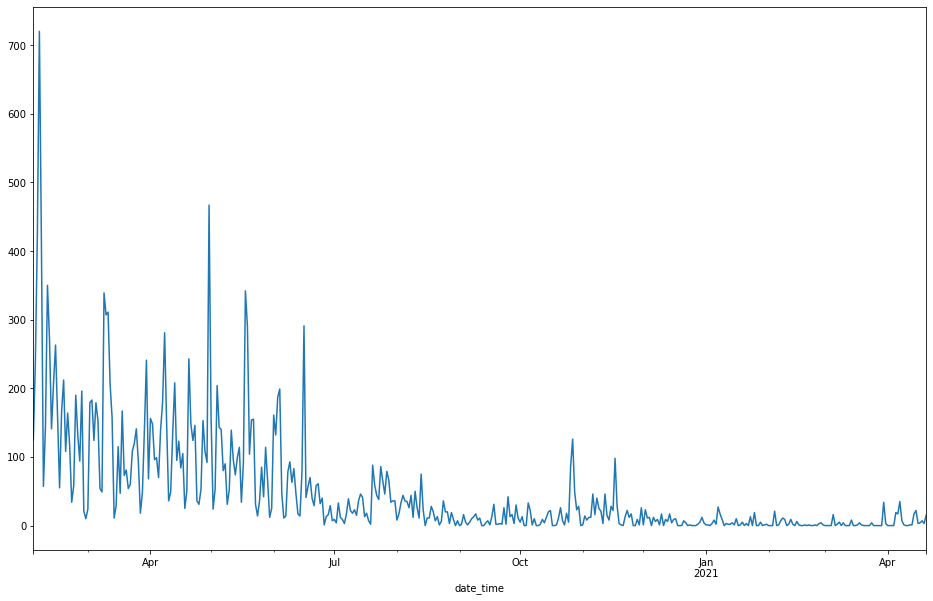

In [85]:
Curie_df = one_program__cohort_df(df_new, 'Curie')
Curie_df.plot(figsize=(16,10))

<AxesSubplot:xlabel='date_time'>

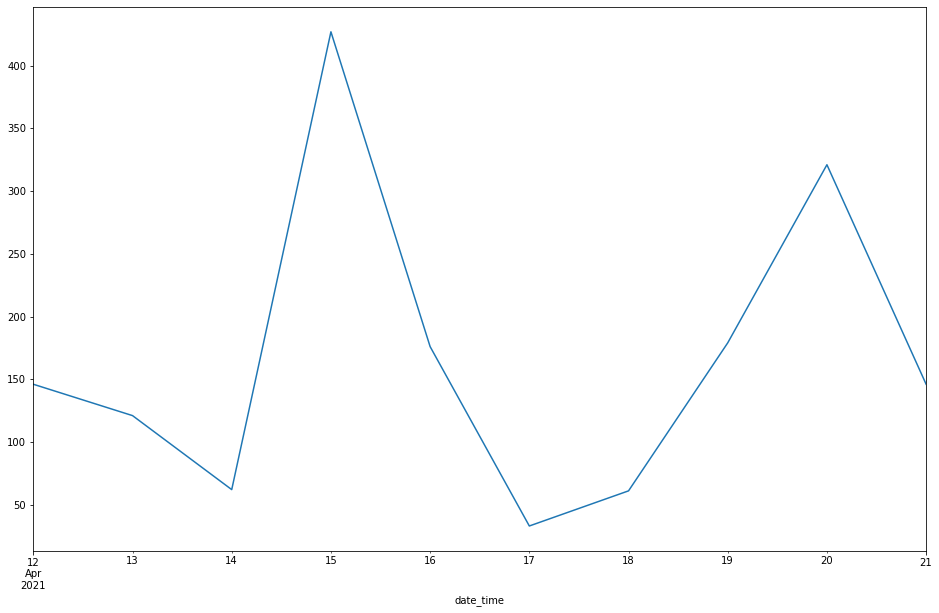

In [84]:
Oberon_df = one_program__cohort_df(df_new, 'Oberon')
Oberon_df.plot(figsize=(16,10))

<AxesSubplot:xlabel='date_time'>

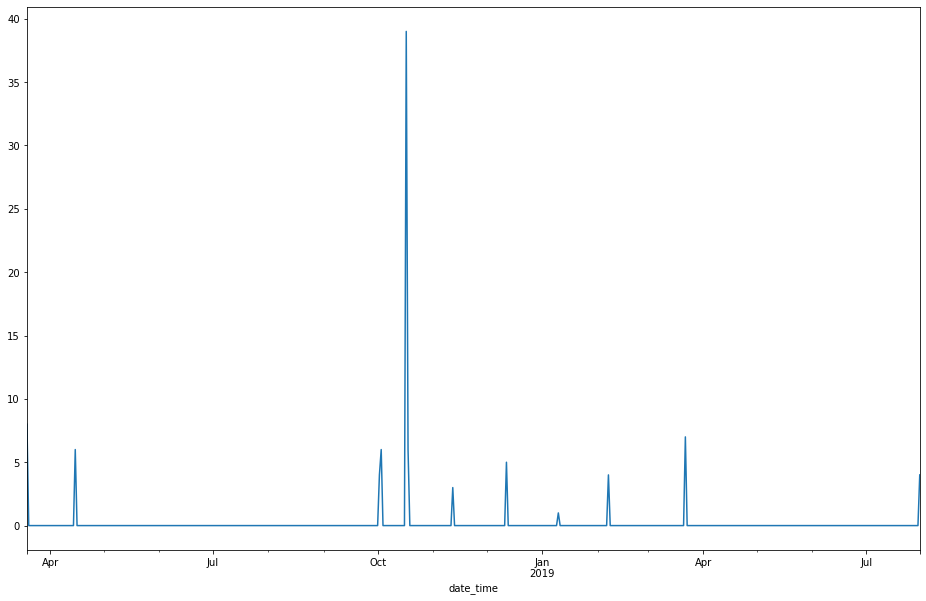

In [86]:
Badlands_df = one_program__cohort_df(df_new, 'Badlands')
Badlands_df.plot(figsize=(16,10))